# Building Q&A App with RAG using Gemini Pro and Langchain

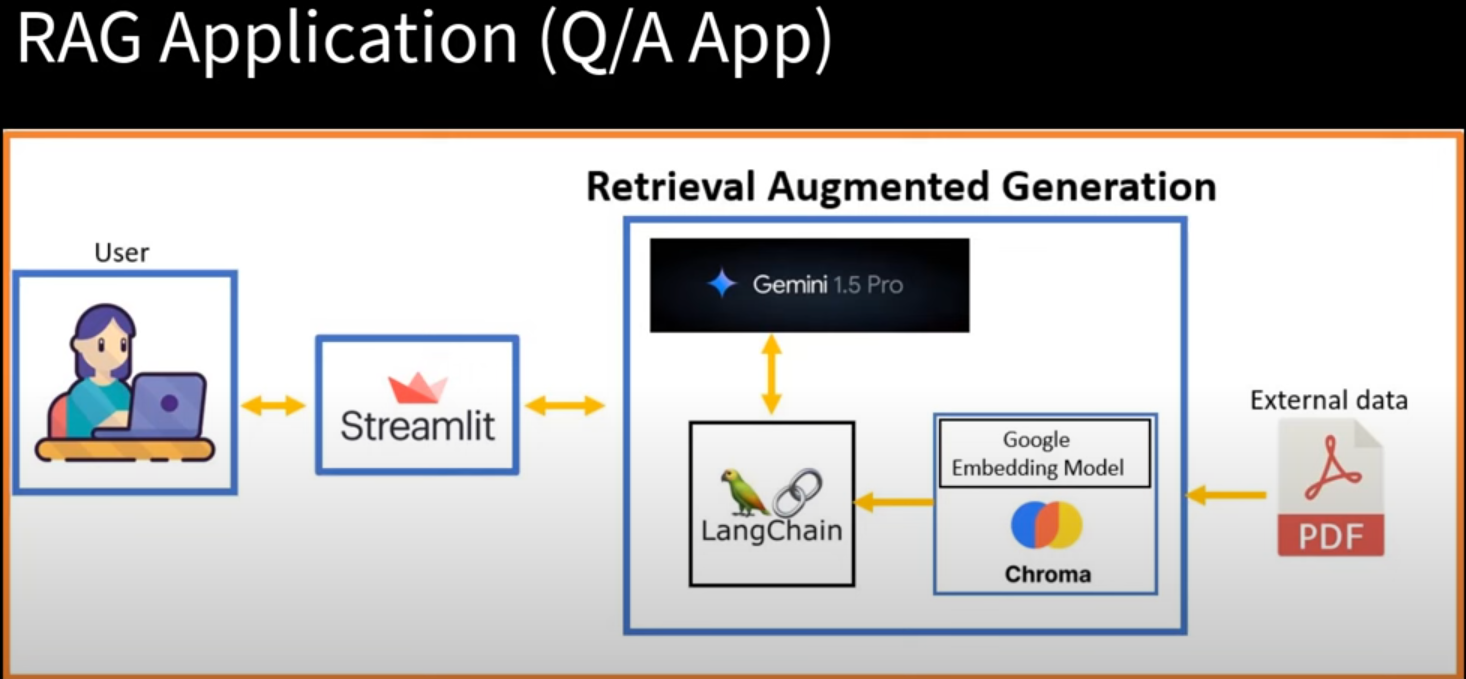

In [ ]:
# !pip install -q langchain langchain_community pypdf langchain_google_genai langchain_chroma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
from google.colab import files
from langchain_community.document_loaders import PyPDFLoader


# Upload PDF file
uploaded = files.upload()

# Get the uploaded file path
for file_name in uploaded.keys():
    pdf_path = file_name
    print(f"Uploaded file: {pdf_path}")

# Load the PDF with LangChain
loader = PyPDFLoader(pdf_path)
pages  = loader.load()

print(f"Loaded {len(pages)} page(s) from the PDF.")

Saving Lec3Part2.pdf to Lec3Part2.pdf
Uploaded file: Lec3Part2.pdf
Loaded 2 page(s) from the PDF.


## Process

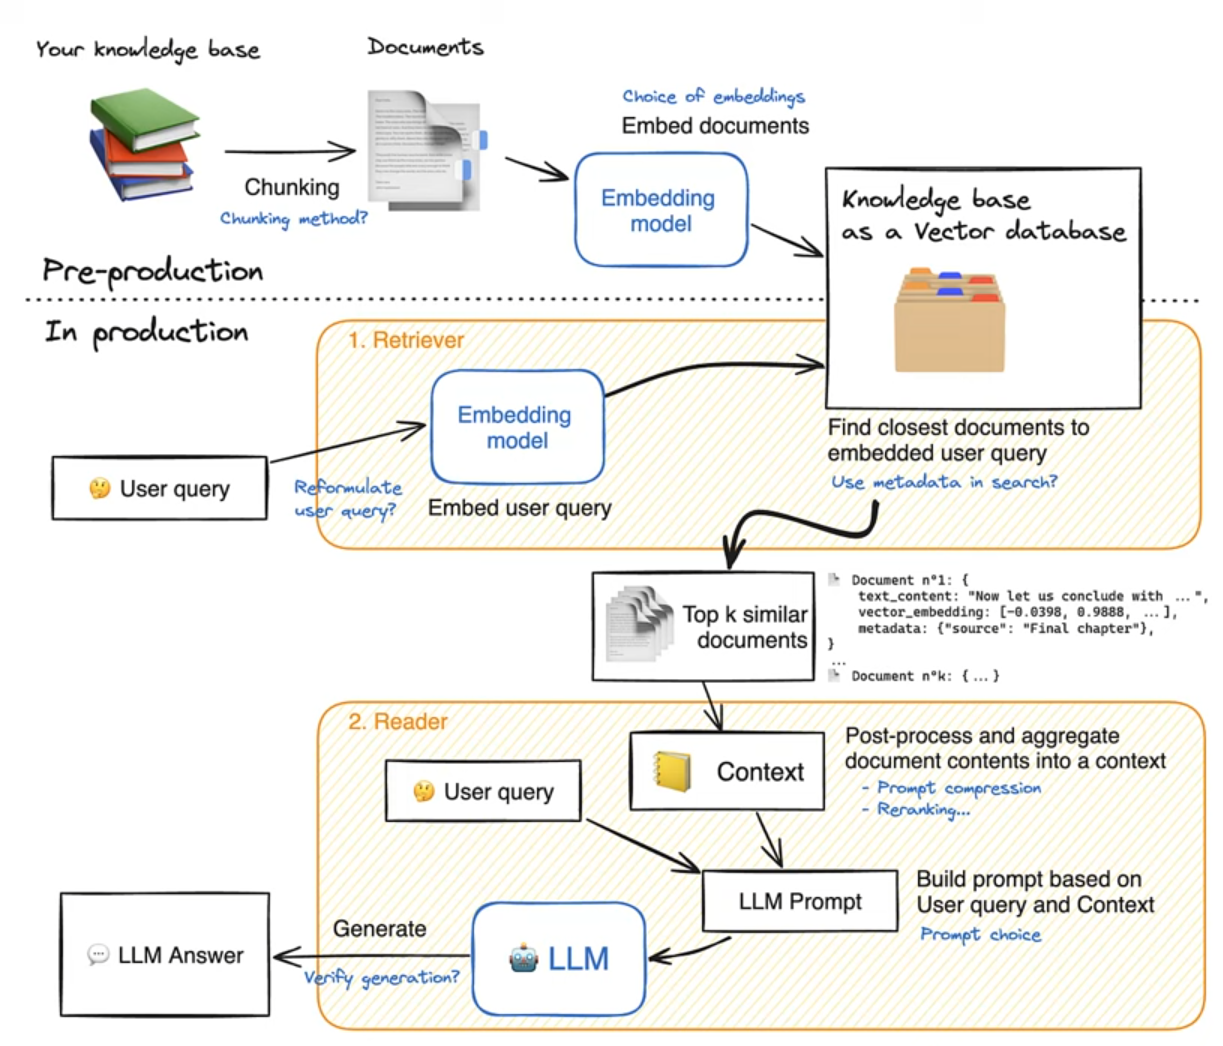

In [ ]:
page_num = 1
for page in pages:
  print("page_number:",page_num,"\n",page.page_content)
  print("-"*120)
  page_num += 1

page_number: 1 
 Requirements Engineering: Questions and Answers
What are requirements?
Requirements are descriptions of system services and constraints generated during the requirements 
engineering process. They define what a system should do and establish constraints on its operation and 
implementation.
What is Requirements Engineering?
Requirements Engineering (RE) is a set of activities concerned with identifying and communicating the 
purpose of a software-intensive system and the contexts in which it will be used. It bridges real-world 
needs with software capabilities.
What are User Stories?
User stories are a technique to express requirements focused on user benefits rather than system 
characteristics. They follow the format:
As a [role/benefactor]
I can [capability/action]
To [business-value/motivation]
What does INVEST stand for in the context of good user stories?
INVEST is an acronym for the qualities of good user stories:
Independent: Does not overlap with other stories

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,
                                               chunk_overlap=50)

chunks = text_splitter.split_documents(pages)

In [ ]:
print("Total Number of Docs or Chunks :",len(chunks))

Total Number of Docs or Chunks : 5


In [ ]:
for chunk in chunks:
  print(chunk.page_content)
  print("-"*120)

Requirements Engineering: Questions and Answers
What are requirements?
Requirements are descriptions of system services and constraints generated during the requirements 
engineering process. They define what a system should do and establish constraints on its operation and 
implementation.
What is Requirements Engineering?
Requirements Engineering (RE) is a set of activities concerned with identifying and communicating the 
purpose of a software-intensive system and the contexts in which it will be used. It bridges real-world 
needs with software capabilities.
What are User Stories?
User stories are a technique to express requirements focused on user benefits rather than system 
characteristics. They follow the format:
As a [role/benefactor]
I can [capability/action]
To [business-value/motivation]
What does INVEST stand for in the context of good user stories?
INVEST is an acronym for the qualities of good user stories:
-----------------------------------------------------------------

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma
from google.colab import userdata
import os

google_api_key = userdata.get('gemini_key')
os.environ["GOOGLE_API_KEY"] = google_api_key


embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vector_db = Chroma.from_documents(chunks, embeddings)

In [ ]:
retriever = vector_db.as_retriever(search_type="similarity", search_kwrags={"k":4})

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0, max_tokens=256)

In [ ]:
# question = "What techniques can be used for requirements elicitation?"
# response = llm.invoke(question)
# print(response)

content='Requirements elicitation is the process of gathering information from stakeholders to understand their needs and expectations for a system or product.  Several techniques can be used, each with its own strengths and weaknesses:\n\n**1. Interviews:**\n\n* **Structured Interviews:** Pre-defined questions are asked in a specific order.  Good for gathering specific information but can limit exploration of unexpected areas.\n* **Unstructured Interviews:** More conversational, allowing for open-ended questions and exploration of new topics.  Can be insightful but requires skilled interviewers and can be difficult to analyze.\n* **Semi-structured Interviews:** A combination of structured and unstructured approaches, providing a balance between focus and flexibility.\n\n**2. Workshops and Focus Groups:**\n\n* **Workshops:** Bring stakeholders together to collaboratively discuss and define requirements.  Facilitated sessions can be highly effective for generating ideas and building con

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

system_prompt = """
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "Not Available Answer . Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}")
    ]
)

In [ ]:
question_answer_chain = create_stuff_documents_chain(llm, prompt )
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [ ]:
user_query = "What techniques can be used for requirements elicitation?"
response = rag_chain.invoke({"input": user_query})
response["answer"]

'Interviews and ethnography are two techniques used for requirements elicitation.  Interviews involve structured or unstructured conversations with stakeholders. Ethnography involves observing stakeholders in their work environment.'